# Regression Exercise 2
In this exercise you will explore two ways of dealing with overfitting --- the first, model selection (one that you have explored before), and the second, regularization.
For this we will use synthetic data and try to fit a polynomial to this data using regression.

## Creating the Data
Run the following code to create the data. This creates a synthetic dataset by adding some random Gaussian noise to a sinusoidal function. Note we used a specific seed so that the generated data would be identical in all runs.

Note: in this exercise you should **use the test set as a validation set**, as we will not care about reporting an approximation for the generalization error of our model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
import warnings
from scipy.linalg import LinAlgWarning

<Figure size 640x480 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


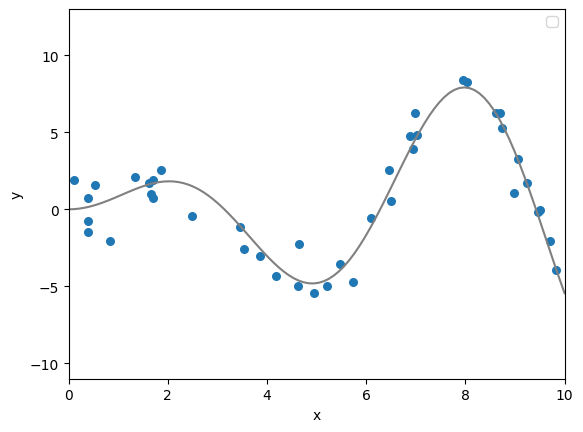

In [2]:
def f(x):
    return x * np.sin(x)

def plot_fit(ax, X_train=None, y_train=None, model=None, poly=None, label=None):
  min_x, max_x = np.floor(min(X_train)), np.ceil(max(X_train))
  x_range = np.linspace(min_x, max_x, 100)
  y = f(x_range)
  min_y, max_y = np.floor(min(y))-5, np.ceil(max(y))+5
  ax.plot(x_range, y, color='gray')
  if X_train is not None and y_train is not None:
    ax.scatter(X_train, y_train, s=30)
  if model is not None and poly is not None:
    x_transform = poly.fit_transform(x_range)
    y_pred = model.predict(x_transform)
    ax.plot(x_range, y_pred, color='red', label=label)
  ax.set_ylim((min_y, max_y))
  ax.set_xlim((min_x, max_x))
  ax.set_ylabel('y')
  ax.set_xlabel('x')
  ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

def create_data(n_samples = 60, test_size=0.3, min_x=0, max_x=10, err_scale=1):
  np.random.seed(9)
  X = np.random.uniform(min_x, max_x, size=n_samples)[:, np.newaxis]
  S = np.random.normal(loc=0, scale=err_scale, size=n_samples)[:, np.newaxis] # loc is mean, and scale is std
  y = f(X) + S
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  return X_train, X_test, y_train, y_test

# generate data
X_train, X_test, y_train, y_test = create_data()
plot_fit(plt.gca(), X_train, y_train)

## Polynomial Regression - Model Selection

**Questions:**
1. Apply polynomial regression to the data, using polynomials with maximal degree of 0 to 11.  **Hint:** Use *sklearn.preprocessing.PolynomialFeatures* and *sklearn.linear_model.LinearRegression*.
2. Plot the fitted polynomial against the training data and the underlying generating function (that is, for each fitted polynomial, plot that polynomial on top of a graph similar to the one plotted above) using the `plot_fit` function above.
3. Do you see underfitting or overfitting? Which is the best degree for this model?
4. Apply model selection technique by choosing the polynomial degree hyperparameter that gives minimum mean squared error on the test data.  
 - **Hint:** Use *sklearn.metrics.mean_squared_error*.
 - Plot: mean squared error as a function of polynomial degree both for `train` and `test` sets.  Put on the plot also the minimal mean squared error of the `test` set.
 - Explain your results.

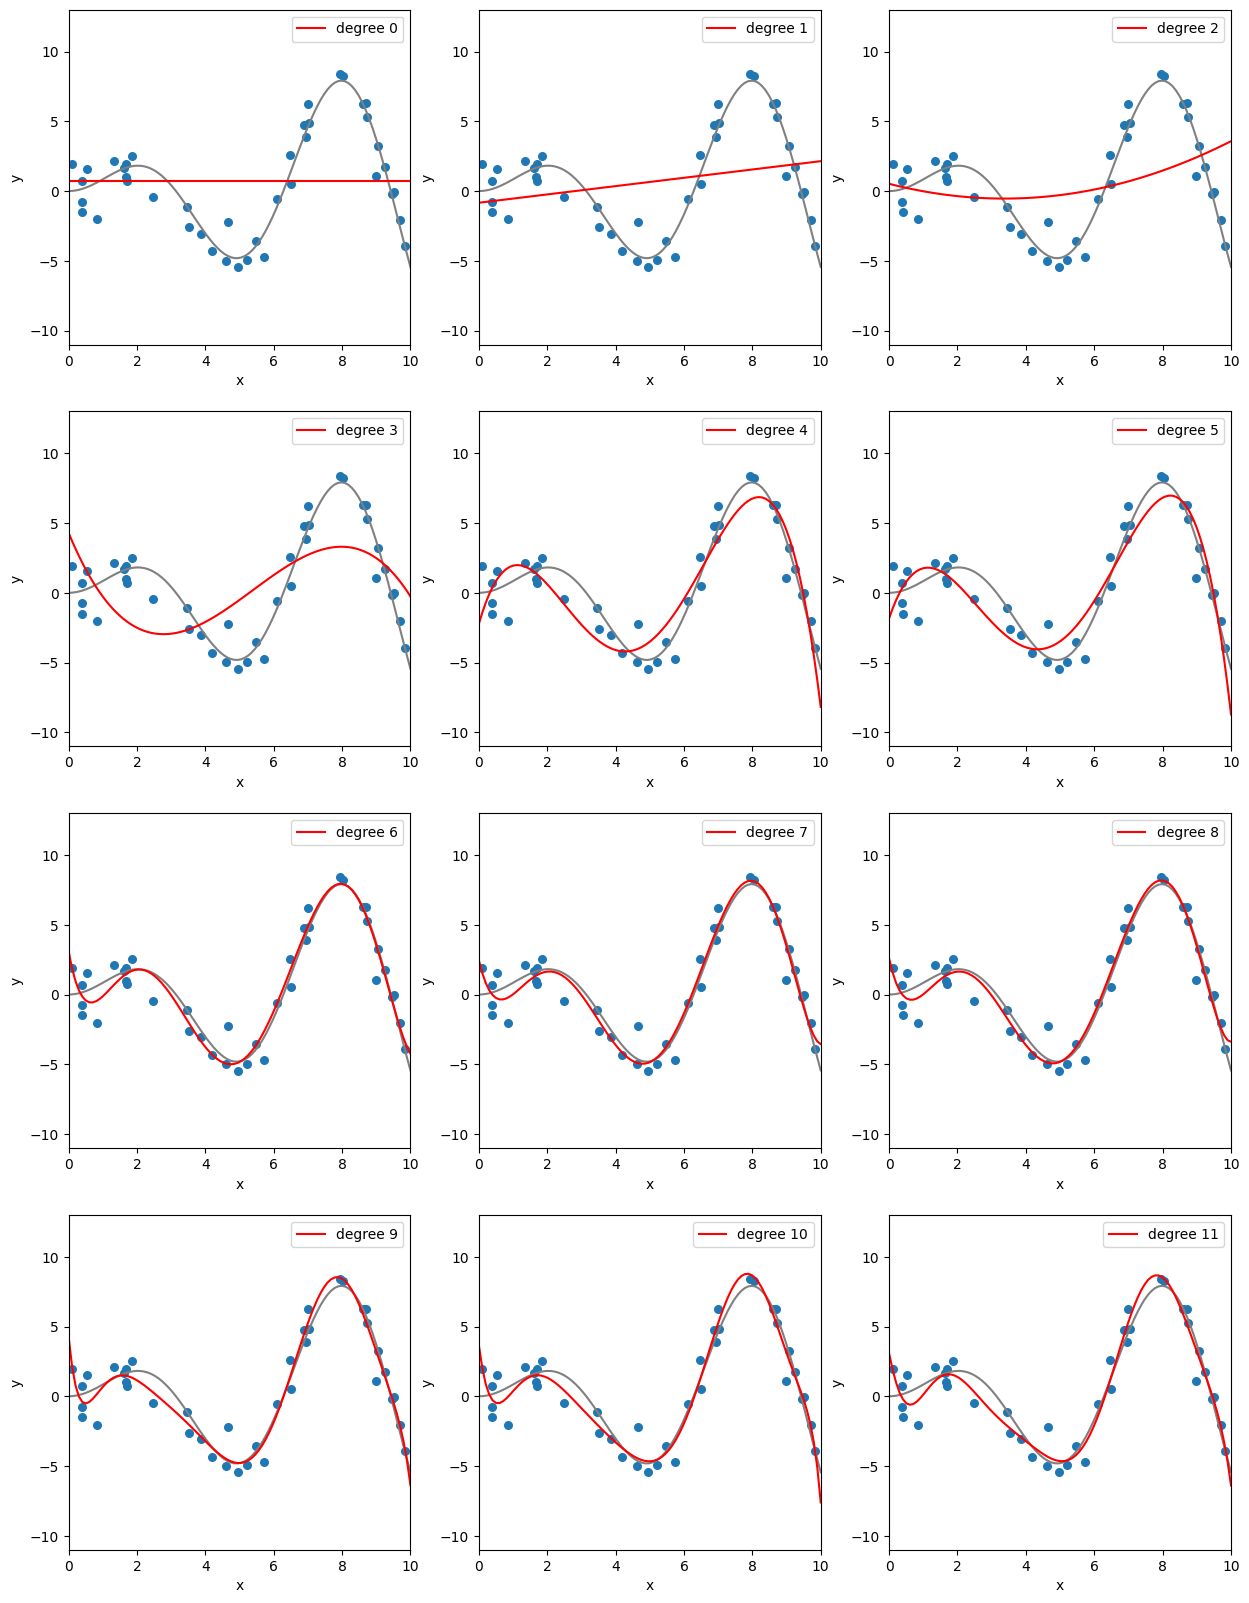

In [3]:
# 1 & 2
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
axs = axs.flatten()
degree = 11

for deg in range(degree + 1):
    poly = PolynomialFeatures(degree=deg)
    X_train_transform = poly.fit_transform(X_train)
    reg = LinearRegression().fit(X_train_transform, y_train)
    ax = axs[deg]
    plot_fit(ax, X_train, y_train, model=reg, poly=poly, label=f"degree {deg}")

3. We can see underfitting for degree 0 to 3, then we see overfitting from degree 6 to 11. The best model would be 5 or 6, even if 6 is overfitting, we can see that it almost completely equals the original curve, while degree 5 is neither overfitting or underfitting. 

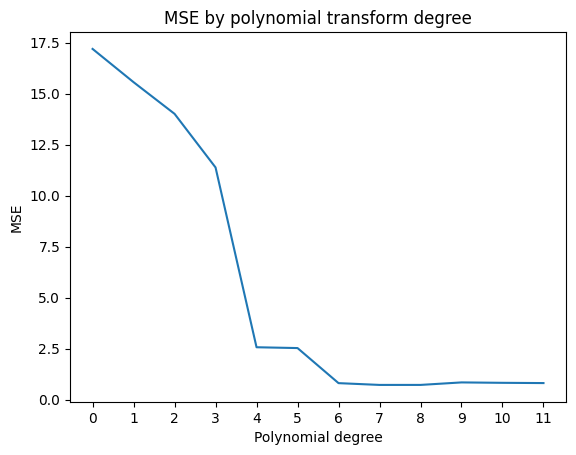

In [4]:
# 4

models = []
y_preds_test = []
y_preds_train = []
mse_test = []

for i in range(12):
  model = make_pipeline(PolynomialFeatures(i), LinearRegression())
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  models.append(model)
  mse_test.append(mean_squared_error(y_test, y_pred))

plt.plot(list(range(degree + 1)), mse_test)
plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.title('MSE by polynomial transform degree')
plt.xticks(np.arange(0, 12))
plt.show()

Based on the curve we would want to use degree 4. We see that when x=4, the MSE stops decreasing.

## Polynomial Regression - Regularization
Now, instead of choosing the best maximal degree to use, we will use polynomial regression with regularization.


**Questions:**
4. Apply polynomial ridge regression with polynomial degree 11, using different regularization parameters (also test the case where the regularization parameter equals 0).
  - For this task you should use L2-norm regularization (ridge regression), which uses the sum of squared parameters as the regularization term (as we saw in class). That is,
$$
L(\boldsymbol\theta) = \frac{1}{n}\sum_{i=0}^n (y_i – \boldsymbol\theta^T \mathbf{x}_i)^2 + \alpha \|\boldsymbol\theta\|_2
$$
where $\alpha$ is the regularization parameter, $\boldsymbol\theta$ is the vector of coefficients including the intercept term and $\mathbf{x}_i$ is the vector of the predictors of the i-th data point including a constant predictor for the intercept.
  - **Hint:** Use *sklearn.linear_model.Ridge* with parameter *alpha=...*
  - Try using `alpha` values between 0 and 1000 and find the best alpha parameter with smallest MSE on `test` set
  - Again, plot the fitted polynomial against the training data and the underlying generating function.
  - This time, also plot the coefficients of the fitted polynomial on a separate plot. **Hint:** You can sort the coefficients to easier compare which model left smaller or large coefficients.  

5. What is the main difference between regularization and model selection approaches? What would be the best regularization parameter to use in this case? Compare your results with the model selection approach for overcoming the the problem of overfitting.

6. Compare the above results with L1-norm regularization (LASSO) instead of the L2-norm, that is
$$
L(\boldsymbol\theta) = \frac{1}{n}\sum_{i=0}^n (y_i – \boldsymbol\theta^T \mathbf{x}_i)^2 + \alpha \|\boldsymbol\theta\|_1
$$
> **Hint**: Use *sklearn.linear_model.Lasso*.

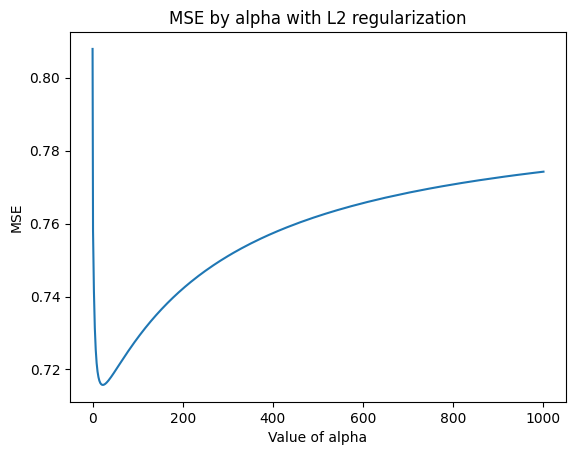

In [5]:
warnings.filterwarnings('ignore')

poly = PolynomialFeatures(degree=11)
X_train_transformed = poly.fit_transform(X_train)
X_test_transformed = poly.transform(X_test)
alphas = range(0, 1001)
mse = []

for a in alphas:
  rreg = Ridge(alpha=a)
  rreg.fit(X_train_transformed, y_train)
  y_pred = rreg.predict(X_test_transformed)
  mse.append(mean_squared_error(y_test, y_pred))

plt.plot(list(alphas), mse)
plt.xlabel('Value of alpha')
plt.ylabel('MSE')
plt.title('MSE by alpha with L2 regularization')
plt.show()

In [6]:
# index of minimum value of MSE (which is value of alpha)
idx = np.argmin(np.array(mse))
idx

23

In [7]:
rreg = Ridge(alpha=idx)
rreg.fit(X_train_transformed, y_train)
y_pred = rreg.predict(X_test_transformed)
mean_squared_error(y_test, y_pred)

0.7157664337121182

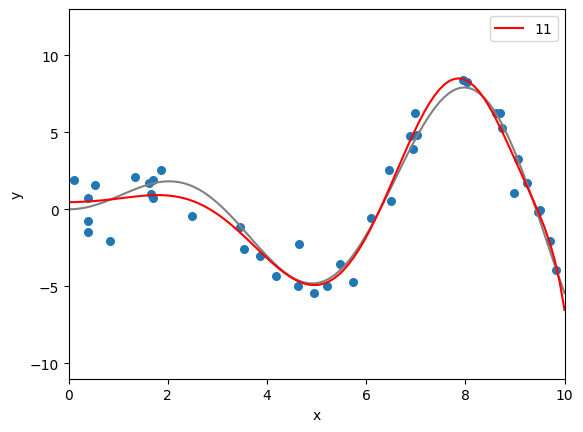

In [8]:
fig, axs = plt.subplots(1, 1)
plot_fit(axs, X_train, y_train, model=rreg, poly=poly, label=11)

Text(0, 0.5, 'Coefficient value')

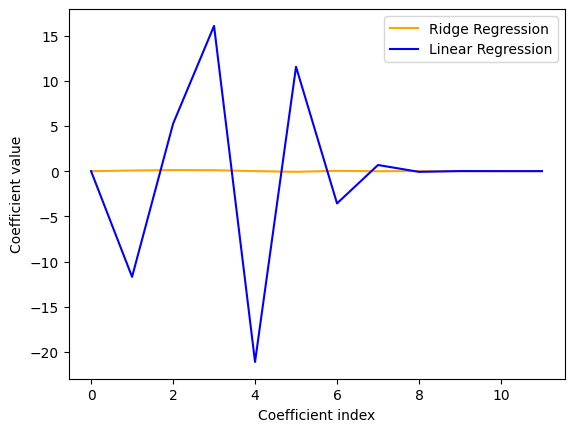

In [9]:
plt.plot(rreg.coef_.T, color='orange', label='Ridge Regression')
plt.plot(reg.coef_.T, color='blue', label='Linear Regression')
plt.legend()
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient value')

In [10]:
rreg.coef_

array([[ 0.00000000e+00,  6.49699075e-02,  1.17949861e-01,
         1.01238105e-01,  3.01902451e-03, -7.51209185e-02,
         3.30194927e-02, -8.03690660e-03,  1.47893403e-03,
        -1.84179779e-04,  1.25131991e-05, -3.41348192e-07]])

In [11]:
reg.coef_

array([[ 0.00000000e+00, -1.16957991e+01,  5.23252632e+00,
         1.60634594e+01, -2.11050519e+01,  1.15467416e+01,
        -3.56974881e+00,  6.78509832e-01, -8.07555286e-02,
         5.86153008e-03, -2.37070404e-04,  4.09274470e-06]])

In this case, when we are fitting a 11-degree polynomial, regularization appears to deal with the overfitting in the best way when alpha=22.

In [12]:
# comparing MSE of both models for degree 11 polynomial
X_train_transformed = poly.fit_transform(X_train)
X_test_transformed = poly.fit_transform(X_test)

y_pred = rreg.predict(X_test_transformed)
mse_rreg = mean_squared_error(y_test, y_pred)

y_pred = reg.predict(X_test_transformed)
mse_reg = mean_squared_error(y_test, y_pred)

print('From regularization, mse equals:', mse_rreg)
print('From polynomial regression, mse equals:', mse_reg)

From regularization, mse equals: 0.7157664337121182
From polynomial regression, mse equals: 0.8078687509772399


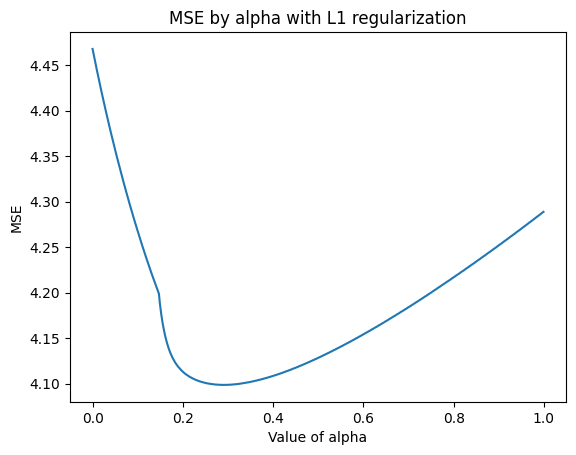

In [13]:
warnings.filterwarnings('ignore')
from sklearn.linear_model import Lasso
mse = []
alphas = np.arange(0, 1, 0.001)
for a in alphas:
  lasso = Lasso(alpha=a)
  lasso.fit(X_train_transformed, y_train)
  y_pred = lasso.predict(X_test_transformed)
  mse.append(mean_squared_error(y_test, y_pred))

plt.plot(list(alphas), mse)
plt.xlabel('Value of alpha')
plt.ylabel('MSE')
plt.title('MSE by alpha with L1 regularization')
plt.show()

In [14]:
min(mse)

4.0984773782857005

In this case both L2 regularizaton and polynomial regression perform better than L1 regression, since MSE from L1 regression is 4.1, while the MSE values from L2 regression or polynomial regression are 0.716 and 0.808, respectively.

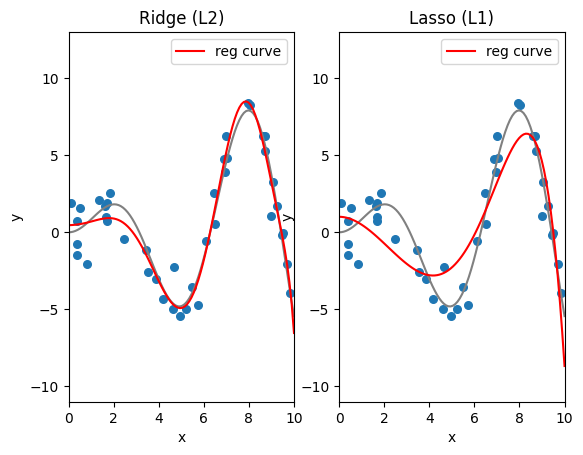

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plot_fit(ax1, X_train, y_train, model=rreg, poly=poly, label='reg curve')
ax1.set_title('Ridge (L2)')
plot_fit(ax2, X_train, y_train, model=lasso, poly=poly, label='reg curve')
ax2.set_title('Lasso (L1)')
plt.show()

We can see that the Ridge regression curve fits the true curve much better than the Lasso regression curve. The Lasso regression appears to have oversimplified the polynomial. In this case, it appears that utilizing higher polymonial features actually improves the model. The lasso model essentially zeroed the features with degrees higher than 4, while the Ridge regression utilized them.


Text(0, 0.5, 'Coefficient value')

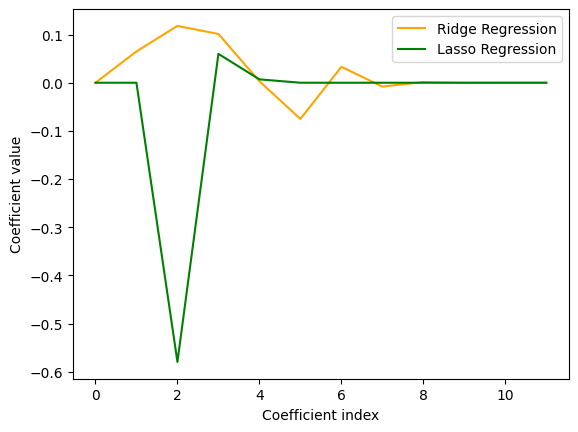

In [16]:
plt.plot(rreg.coef_.T, color='orange', label='Ridge Regression')
plt.plot(lasso.coef_.T, color='green', label='Lasso Regression')
plt.legend()
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient value')